In [2]:
# Interpretation of the shear strength prediction resuls
# v 1.0
# 2020.05

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.ensemble
import sklearn.tree
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

c:\Users\Lip\.conda\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define an additional metric 
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / abs(true))


In [4]:
# load JS visualization
shap.initjs()

In [5]:
# load the shear strength database
data = pd.read_csv('Swall-shap.csv')
print(data.head())

X = data.loc[:, data.columns != 'Vu']
y = data['Vu']

    Hw    Lw  tw    fc      rv    fyv      rh    fyh      rL    fyL      N  \
0  750  2250  80  26.0  0.0049  623.7  0.0047  623.7  0.0081  358.9  369.7   
1  750  2250  80  24.6  0.0016  623.7  0.0014  623.7  0.0081  358.9  367.5   
2  750  2250  80  26.0  0.0016  623.7  0.0014  623.7  0.0081  358.9  369.7   
3  750  2250  50  24.6  0.0026  623.7  0.0022  623.7  0.0081  358.9  368.1   
4  750  2250  50  26.0  0.0079  623.7  0.0076  623.7  0.0081  358.9  368.6   

      tf     Hf     Vu  
0  250.0  250.0  654.1  
1  250.0  250.0  559.0  
2  250.0  250.0  524.7  
3  250.0  250.0  466.8  
4  250.0  250.0  783.6  


In [6]:
# train XGBoost model
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.3, n_estimators=100, min_child_weight=7, subsample=0.8, colsample_bytree=0.7, reg_lambda=0.4, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [7]:
# 10-fold cv results for hyper-parameter validation
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs = -1)
print(np.sqrt(-scores.mean()))

119.51843942765797


In [8]:
# testing the model
Z_1 = model.predict(X_train)
Z_2 = model.predict(X_test)

In [9]:
print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.998622526000658 RMSE: 24.16821517531084 MAE: 14.492608514477318 MAPE: 7.783690318102694 %
Testing R2: 0.9783362847037493 RMSE: 92.29667768207031 MAE: 48.78949480347961 MAPE: 15.887525124376921 %


In [10]:
Z_3 = model.predict(X)

xx = np.zeros(shape=(434,2))
xx[:,0]=y
xx[:,1]=Z_3
np.savetxt('XGB.csv', xx, delimiter = ',') 


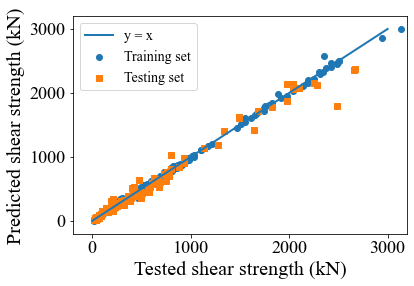

In [11]:
# plot the shear strength prediction results
xx = np.linspace(0, 3000, 100)
yy = xx

plt.figure()
plt.plot(xx, yy, linewidth=2)
plt.scatter(y_train, Z_1, marker='o')
plt.scatter(y_test, Z_2, marker='s')

plt.tick_params (axis='both',which='major',labelsize=18)
plt.yticks(fontproperties = 'Times New Roman', size = 18)
plt.xticks(fontproperties = 'Times New Roman', size = 18)

font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 20,}
plt.axis('tight')
plt.xlabel('Tested shear strength (kN)', font1)
plt.ylabel('Predicted shear strength (kN)', font1)
plt.xlim([-200, 3200])
plt.ylim([-200, 3200])
plt.legend(['y = x','Training set','Testing set'], loc = 'upper left', prop={'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 14,})
plt.savefig('Prediction_xgb.pdf', dpi=600, bbox_inches = 'tight', format='pdf')
plt.show()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(434, 13)


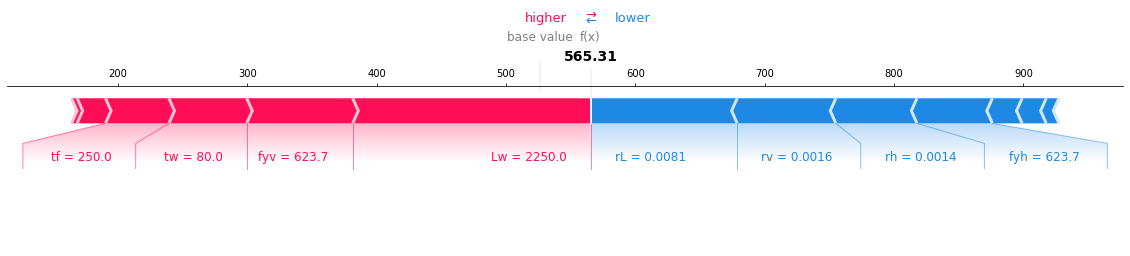

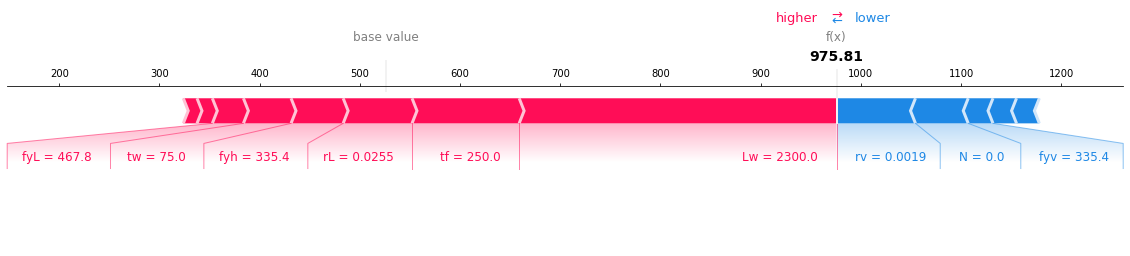

In [12]:
# explain the model's predictions using SHAP
X_shap = pd.DataFrame(X, columns = X.columns)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
print(shap_values.shape)
np.savetxt('shap values.csv', shap_values, delimiter = ',') 
# visualize the j-th prediction's explanation and then the entire set
y_base = explainer.expected_value
data['pred'] = model.predict(X)

shap.force_plot(explainer.expected_value, shap_values[2], X.iloc[2], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[16], X.iloc[16], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values, X)

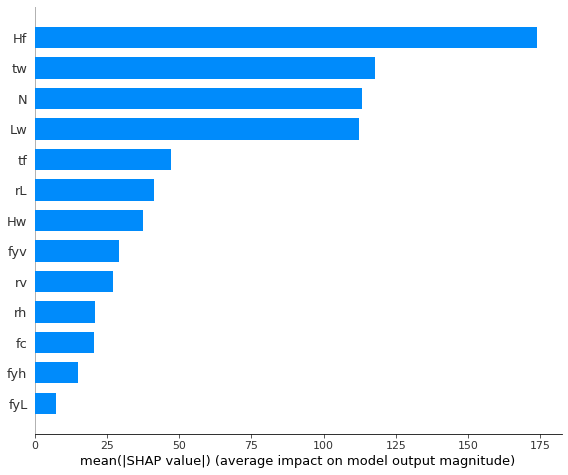

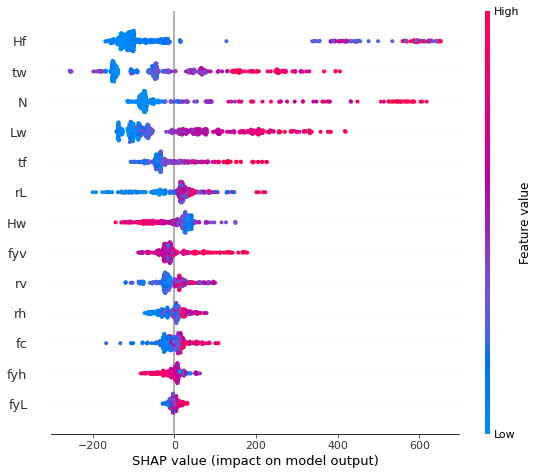

In [13]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_shap, plot_type="bar")
shap.summary_plot (shap_values, X_shap, show=False)


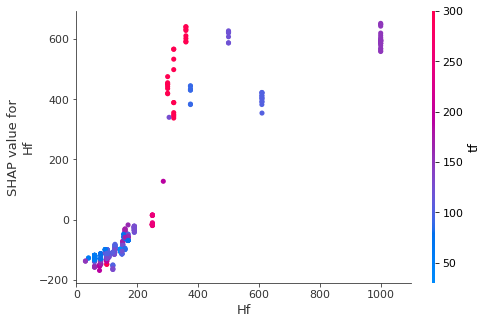

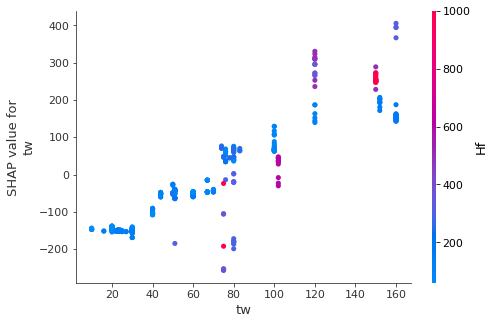

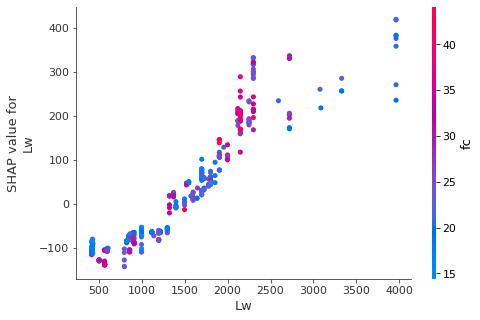

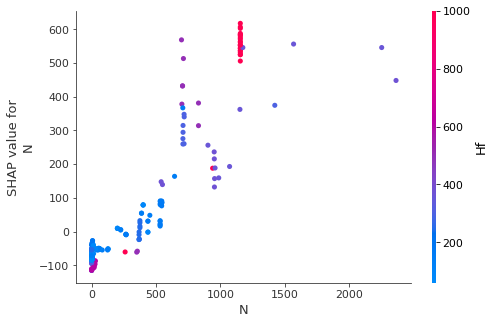

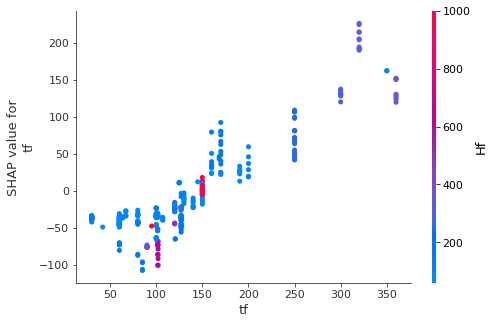

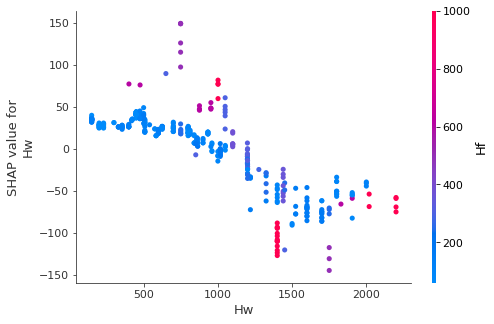

In [14]:
# # creat a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot ('Hf', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
plt.xlim([0, 1100])
shap.dependence_plot ('tw', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('Lw', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('N', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('tf', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('Hw', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


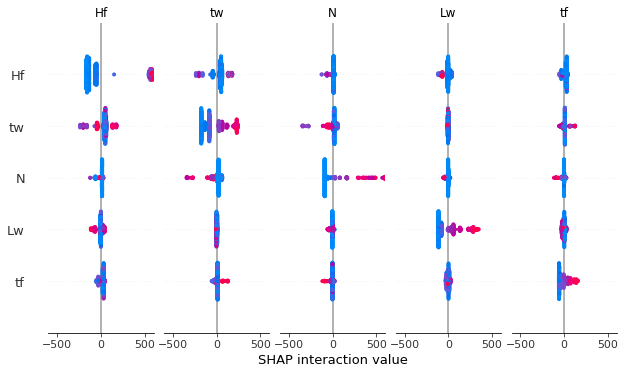

In [15]:
# # creat a SHAP interaction plot to show the interactive effect of several features
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_shap)
shap.summary_plot(shap_interaction_values, X_shap, max_display=5, show=False)

In [16]:
plt.show()